## Trending YouTube Video Statistics
该数据集包括数月（并且还在不断增加）关于 YouTube 每日热门视频的数据。 包括美国、英国、德国、加拿大、法国地区、俄罗斯、墨西哥、韩国、日本和印度地区（分别为美国、英国、德国、加拿大、法国、俄罗斯、墨西哥、韩国、日本和印度）的数据，每天最多列出 200 个热门视频。

每个区域的数据都在一个单独的文件中。 数据包括视频标题、频道标题、发布时间、标签、观看次数、喜欢和不喜欢、描述和评论计数。

数据还包括一个 category_id 字段，该字段因地区而异。 要检索特定视频的类别，请在关联的 JSON 中找到它。 数据集中的五个区域中的每一个都包含一个这样的文件。

对其他可用的课程数据集进行了分析，该数据集所涉及到的属性之间的关联性比较强，有值得进行频繁模式和关联规则挖掘的潜力。

### 属性分析与数据预处理
- 导入数据并观察属性
观察各个国家的数据，由于俄罗斯、墨西哥、韩国、日本和印度的数据不是utf-8形式，这里选取数据样本最大的美国区域数据进行读入和分析
由于orange库中带有关联规则算法相关的函数可以调用，因此先引入orange库

In [ ]:
conda install orange3

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: \ 

In [21]:
import pandas as pd
import numpy as np
import json as js
import matplotlib.pyplot as plt
import seaborn as sns
import Orange as og
import orangecontrib.associate.fpgrowth as oaf
%matplotlib inline

data = pd.read_csv("USvideos.csv",encoding="utf-8")
data.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [22]:
data.shape

(40949, 16)

#### 通过观察部分数据可以得出，数据所包含的属性有video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,discription这16个属性，我挑选出个人认为比较有频繁模式和关联规则挖掘潜力的属性
- 频道标题：channel_title
- 类别id：category_id
- 标签:tags
- 观看人数:views
- 喜欢与不喜欢:likes & dislikes
- 评论数:comments_count
### 将Json文件导入，用类别的名称来代替ID号，并且将数值属性调整为非数值状态便于后面进行频繁模式操作

In [23]:
with open('US_category_id.json') as f:
    jdata=js.load(f)
    f.close()

#将类别id号替换成类别名称
id2name={}
for i in range(len(jdata['items'])):
    id2name[jdata['items'][i]['id']]=jdata['items'][i]['snippet']['title']
for i in range(len(data)):
    id=data.loc[i,'category_id']
    data.loc[i,'category_id']=id2name[str(id)]
data['category_id'].head(5) #替换后的效果

0    People & Blogs
1     Entertainment
2            Comedy
3     Entertainment
4     Entertainment
Name: category_id, dtype: object

### 接下来进行喜欢与不喜欢、观看人数、评论数将数值属性转换为非数值属性的处理
- likes & dislikes可以分为三类标签，其中当$likes\div(likes+dislikes) \geq 75\%$时，我们标记该视频为Good;当$likes\div(likes+dislikes) \leq 25\%$时，我们标记该视频为Bad;位于中间的我们标记该视频为Medium。

In [24]:
like = []
np.seterr(invalid='ignore') #可能有分母为零的时候，进行忽略，不然会报错
for i in range(len(data)):
    temp=data.loc[i, 'likes']/(data.loc[i, 'likes']+data.loc[i, 'dislikes'])
    if temp >= 0.75:
        like.append('Good')
    elif temp <= 0.25:
        like.append('Bad')
    else:
        like.append('Medium')
print(like[0:100])

['Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Medium', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Medium', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Medium', 'Medium', 'Medium', 'Good', 'Good', 'Medium', 'Medium', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Medium', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Medium', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good']


- 对于views，首先计算全部视频views的四分之一分位数和四分之三分位数，大于四分之三分位数的数据记为"high view"，小于四分之一分位数的数据记为"low view"，其余的记为"medium view"。

In [25]:
views = data['views']
quarter = views.quantile(0.25)
three_quarters = views.quantile(0.75)
view = []
for i in data['views']:
    if int(i) >= three_quarters:
        view.append('high view')
    elif int(i) <= quarter:
        view.append('low view')
    else:
        view.append('medium view')
print(view[:100])

['medium view', 'high view', 'high view', 'medium view', 'high view', 'low view', 'high view', 'medium view', 'medium view', 'medium view', 'low view', 'low view', 'medium view', 'medium view', 'low view', 'low view', 'medium view', 'low view', 'low view', 'low view', 'low view', 'low view', 'low view', 'low view', 'low view', 'low view', 'low view', 'low view', 'low view', 'low view', 'low view', 'low view', 'high view', 'low view', 'low view', 'low view', 'medium view', 'low view', 'medium view', 'low view', 'low view', 'low view', 'low view', 'medium view', 'medium view', 'medium view', 'low view', 'medium view', 'low view', 'high view', 'high view', 'low view', 'medium view', 'high view', 'low view', 'medium view', 'low view', 'low view', 'low view', 'medium view', 'medium view', 'low view', 'medium view', 'high view', 'low view', 'medium view', 'high view', 'high view', 'low view', 'high view', 'high view', 'low view', 'low view', 'low view', 'medium view', 'low view', 'low view',

- 对于comments，首先计算全部视频comments的四分之一分位数和四分之三分位数，大于四分之三分位数的数据记为"high comment"，小于四分之一分位数的数据记为"low comment"，其余的记为"medium comment"。

In [26]:
comments = data['comment_count']
quarter = comments.quantile(0.25)
three_quarters = comments.quantile(0.75)
comment = []
for i in data['comment_count']:
    if i >= three_quarters:
        comment.append('high comment')
    elif i <= quarter:
        comment.append('low comment')
    else:
        comment.append('medium comment')
print(comment[0:100])

['high comment', 'high comment', 'high comment', 'medium comment', 'high comment', 'medium comment', 'medium comment', 'medium comment', 'low comment', 'medium comment', 'low comment', 'medium comment', 'high comment', 'medium comment', 'medium comment', 'medium comment', 'medium comment', 'low comment', 'medium comment', 'medium comment', 'medium comment', 'low comment', 'medium comment', 'medium comment', 'low comment', 'medium comment', 'low comment', 'medium comment', 'low comment', 'low comment', 'low comment', 'low comment', 'high comment', 'medium comment', 'low comment', 'low comment', 'medium comment', 'low comment', 'medium comment', 'low comment', 'low comment', 'low comment', 'low comment', 'high comment', 'medium comment', 'medium comment', 'low comment', 'medium comment', 'low comment', 'high comment', 'high comment', 'low comment', 'medium comment', 'high comment', 'low comment', 'low comment', 'low comment', 'low comment', 'low comment', 'medium comment', 'medium commen

- 替换原始数据中的数值属性为非数值属性并且删除不要的属性

In [28]:
data1 = data.drop(['views', 'likes', 'dislikes', 'comment_count'], axis = 1)
data_pro = data1.drop(['video_id', 'trending_date', 'publish_time', 'video_error_or_removed', 'description', 'thumbnail_link', 'title', 'comments_disabled', 'ratings_disabled'], axis = 1)
data_pro.insert(0, 'views', view)
data_pro.insert(0, 'like', like)
data_pro.insert(0, 'comment_count', comment)
data_pro.head(10)

,comment_count,like,views,channel_title,category_id,tags
0,high comment,Good,medium view,CaseyNeistat,People & Blogs,SHANtell martin
1,high comment,Good,high view,LastWeekTonight,Entertainment,"last week tonight trump presidency|""last week ..."
2,high comment,Good,high view,Rudy Mancuso,Comedy,"racist superman|""rudy""|""mancuso""|""king""|""bach""..."
3,medium comment,Good,medium view,Good Mythical Morning,Entertainment,"rhett and link|""gmm""|""good mythical morning""|""..."
4,high comment,Good,high view,nigahiga,Entertainment,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""..."
5,medium comment,Good,low view,iJustine,Science & Technology,"ijustine|""week with iPhone X""|""iphone x""|""appl..."
6,medium comment,Good,high view,Saturday Night Live,Entertainment,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi..."
7,medium comment,Good,medium view,CrazyRussianHacker,Science & Technology,"5 Ice Cream Gadgets|""Ice Cream""|""Cream Sandwic..."
8,low comment,Good,medium view,20th Century Fox,Film & Animation,"Trailer|""Hugh Jackman""|""Michelle Williams""|""Za..."
9,medium comment,Good,medium view,Vox,News & Politics,"vox.com|""vox""|""explain""|""shift change""|""future..."


## 方法分析
关联分析方法在python中有两个包包含具体实现：
- pymining：根据Apriori算法进行关联规则挖掘
- Orange3的关联规则：根据FP-growth算法进行关联规则挖掘

最终我选用Orange库进行关联规则实现，原因是：
- FP-growth算法比Apriori算法时间复杂度低
- Orange3是一整套数据挖掘工具包，学习后可以熟悉相关操作，进行其他的数据挖掘算法的研究
- pymining不再维护，Orange3仍然是一个非常活跃的包，更新频繁
- Orange3实现的结果比较多，除了规则外，还能够计算出评价结果的相关数据

> 注意：Orange3的关联分析模块安装时需要在Anaconda的命令行窗口中输入以下命令:
pip install orange3-associate

因为orangecontrib.associate.fpgrowth包在进行频繁模式与关联规则挖掘时，数据必须为整数类型，因此需要将字符串数据存储为一个对应的整数hash表。

In [30]:
id2str = {}   # 整数编码 —> 字符串
str2id = {}   # 字符串 -> 整数编码
id = 0
transaction = []
for i in range(len(data_pro)):
    one = []
    for j in data_pro.columns:
        # 拆分tags
        if j == 'tags':
            str_arr = data_pro.loc[i, j].split('|')
            for s in str_arr:
                if s in str2id:
                    one.append(str2id[s])
                else:
                    id2str[id] = s
                    str2id[s] = id
                    one.append(id)
                    id += 1
        else:
            if data_pro.loc[i, j] in str2id:
                one.append(str2id[data_pro.loc[i, j]])
            else:
                id2str[id] = data_pro.loc[i, j]
                str2id[data_pro.loc[i, j]] = id
                one.append(id)
                id += 1
    transaction.append(one)
print(transaction[:10])

[[0, 1, 2, 3, 4, 5], [0, 1, 6, 7, 8, 9, 10, 11, 12], [0, 1, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37], [38, 1, 2, 39, 8, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66], [0, 1, 6, 67, 8, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 64, 65, 78, 79], [38, 1, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], [38, 1, 6, 90, 8, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 64, 107, 65, 108, 109, 110, 57, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129], [38, 1, 2, 130, 82, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143], [144, 1, 2, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174], [38, 1, 2, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196]

## 频繁模式
- 函数fpgrowth.frequent_itemsets(X, min_support=0.2) 这个函数代表计算给定支持度下得到的频繁项集，返回的是一个频繁项集的列表生成
- min_support代表关联规则设置的置信度，默认为0.2

> 注意：该函数返回的列表生成器只能使用一次，我在这里调试时出了好多次错误，每次用完后我调用这个生成器， 然后总是得到空集，所以干脆直接返回值包上字典函数dict并返回给变量itemsets，这样可以多次使用

In [46]:
frequent_pattern = list(oaf.frequent_itemsets(transaction))
for i in frequent_pattern:
    x = []
    y = i[1]
    for j in i[0]:
        x.append(id2str[j])
    print(x, abs_sup, round(float(y) / len(data), 2))

['high comment'] 9174 0.25
['Good'] 9174 0.95
['high comment', 'Good'] 9174 0.24
['medium view'] 9174 0.5
['Good', 'medium view'] 9174 0.48
['high view'] 9174 0.25
['Good', 'high view'] 9174 0.24
['Entertainment'] 9174 0.24
['Entertainment', 'Good'] 9174 0.23
['medium comment'] 9174 0.5
['Good', 'medium comment'] 9174 0.48
['medium view', 'medium comment'] 9174 0.37
['Good', 'medium view', 'medium comment'] 9174 0.36
['low view'] 9174 0.25
['low view', 'Good'] 9174 0.22
['low comment'] 9174 0.25
['low comment', 'Good'] 9174 0.22


## 关联规则
- fpgrowth.association_rules(itemsets, min_confidence, itemset=None) 这个函数代表在给定置信度和第一步得到的频繁项集的情况下得到关联规则

In [47]:
frequent_pattern = list(oaf.frequent_itemsets(transaction, 0.2))
rules = list(oaf.association_rules(dict(frequent_pattern), 0.2))
for i in rules:
    x = []
    y = []
    for j in i[0]:
        x.append(id2str[j])
    for j in i[1]:
        y.append(id2str[j])
    print(x, "->", y, i[2], round(i[3],2))

['medium view', 'medium comment'] -> ['Good'] 14623 0.97
['Good', 'medium comment'] -> ['medium view'] 14623 0.74
['medium comment'] -> ['Good', 'medium view'] 14623 0.71
['Good', 'medium view'] -> ['medium comment'] 14623 0.74
['medium view'] -> ['Good', 'medium comment'] 14623 0.71
['Good'] -> ['medium view', 'medium comment'] 14623 0.38
['Good'] -> ['high comment'] 9904 0.26
['high comment'] -> ['Good'] 9904 0.97
['medium view'] -> ['Good'] 19665 0.96
['Good'] -> ['medium view'] 19665 0.51
['high view'] -> ['Good'] 9965 0.97
['Good'] -> ['high view'] 9965 0.26
['Good'] -> ['Entertainment'] 9371 0.24
['Entertainment'] -> ['Good'] 9371 0.94
['medium comment'] -> ['Good'] 19657 0.96
['Good'] -> ['medium comment'] 19657 0.51
['medium comment'] -> ['medium view'] 15081 0.74
['medium view'] -> ['medium comment'] 15081 0.74
['Good'] -> ['low view'] 9105 0.24
['low view'] -> ['Good'] 9105 0.89
['Good'] -> ['low comment'] 9174 0.24
['low comment'] -> ['Good'] 9174 0.9


- 观察生成规则

In [45]:
print(len(rules))

22


### 共有22条生产规则，对此进行评价分析，采用Lift和卡方进行评价。
## Lift

In [49]:
Lift = list(oaf.rules_stats(oaf.association_rules(dict(frequent_pattern), 0.2), dict(oaf.frequent_itemsets(transaction, 0.2)), len(data_pro)))
for i in Lift:
    x = []
    y = []
    for j in i[0]:
        x.append(id2str[j])
    for j in i[1]:
        y.append(id2str[j])
    print(x, "->", y, round(i[6], 2))

['medium view', 'medium comment'] -> ['Good'] 1.03
['Good', 'medium comment'] -> ['medium view'] 1.49
['medium comment'] -> ['Good', 'medium view'] 1.49
['Good', 'medium view'] -> ['medium comment'] 1.49
['medium view'] -> ['Good', 'medium comment'] 1.49
['Good'] -> ['medium view', 'medium comment'] 1.03
['Good'] -> ['high comment'] 1.02
['high comment'] -> ['Good'] 1.02
['medium view'] -> ['Good'] 1.02
['Good'] -> ['medium view'] 1.02
['high view'] -> ['Good'] 1.03
['Good'] -> ['high view'] 1.03
['Good'] -> ['Entertainment'] 0.99
['Entertainment'] -> ['Good'] 0.99
['medium comment'] -> ['Good'] 1.02
['Good'] -> ['medium comment'] 1.02
['medium comment'] -> ['medium view'] 1.47
['medium view'] -> ['medium comment'] 1.47
['Good'] -> ['low view'] 0.94
['low view'] -> ['Good'] 0.94
['Good'] -> ['low comment'] 0.95
['low comment'] -> ['Good'] 0.95


## 卡方

In [50]:
kulc = []
visit = [False for i in range(len(rules))]
for i in range(len(rules)):
    if visit[i] == True:
        continue
    visit[i] = True
    for j in range(len(rules)):
        if visit[j] == True:
            continue
        if rules[j][0] == rules[i][1] and rules[j][1] == rules[i][0]:
            one = []
            x = []
            y = []
            for k in rules[i][0]:
                x.append(id2str[k])
            for k in rules[i][1]:
                y.append(id2str[k])
            one.append(rules[i][0])
            one.append(rules[i][1])
            one.append((rules[i][3] + rules[j][3])/2)
            kulc.append(one)
            print('Kulc(', x, y, ') = ', round((rules[i][3] + rules[j][3])/2, 2))
            visit[j] = True

Kulc( ['medium view', 'medium comment'] ['Good'] ) =  0.67
Kulc( ['Good', 'medium comment'] ['medium view'] ) =  0.73
Kulc( ['medium comment'] ['Good', 'medium view'] ) =  0.73
Kulc( ['Good'] ['high comment'] ) =  0.61
Kulc( ['medium view'] ['Good'] ) =  0.73
Kulc( ['high view'] ['Good'] ) =  0.62
Kulc( ['Good'] ['Entertainment'] ) =  0.59
Kulc( ['medium comment'] ['Good'] ) =  0.73
Kulc( ['medium comment'] ['medium view'] ) =  0.74
Kulc( ['Good'] ['low view'] ) =  0.56
Kulc( ['Good'] ['low comment'] ) =  0.57


### 规则评价
- Lift评价标准用来检测X与Y是否独立，如果Lift值大于1则说明X、Y正相关；Lift小于1则说明X、Y负相关
- Kulc用来评价每条规则的反向规则

**观察数据可以发现，Lift数值较大或较小的即关联性大的数据有6条：**
- ['Good', 'medium comment'] -> ['medium view'] 1.49
- ['medium comment'] -> ['Good', 'medium view'] 1.49
- ['Good', 'medium view'] -> ['medium comment'] 1.49
- ['medium view'] -> ['Good', 'medium comment'] 1.49
- ['medium comment'] -> ['medium view'] 1.47
- ['medium view'] -> ['medium comment'] 1.47

**观察数据可以发现，Kulc数值较大即关联性大的数据有5条：**
- Kulc( ['Good', 'medium comment'] ['medium view'] ) =  0.73
- Kulc( ['medium comment'] ['Good', 'medium view'] ) =  0.73
- Kulc( ['medium view'] ['Good'] ) =  0.73
- Kulc( ['medium comment'] ['Good'] ) =  0.73
- Kulc( ['medium comment'] ['medium view'] ) =  0.74

因此可以得出：
- 喜爱度高且评价中等的视频会有中等播放量
- 喜爱度高且中等播放量的视频会有中等数量的评价
- 中等评价数量的视频喜爱度高且有中等播放量
- 中等播放量的视频喜爱度高且有中等评论数
- 中等评论数的视频有中等播放量

## 可视化展示
- 置信度热力图绘制

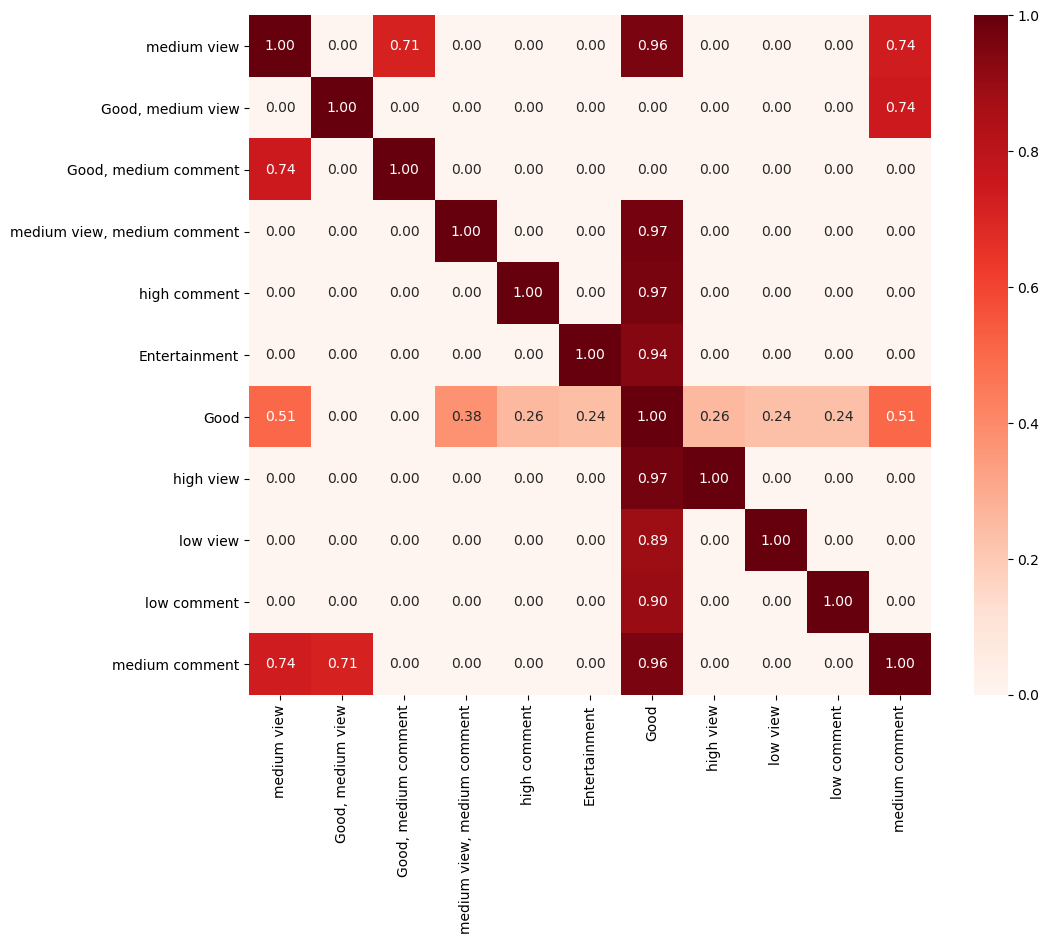

In [54]:
conf_matrix = []
rules_column = set()

for i in range(len(Lift)):
    rules_column.add(Lift[i][0])
for i in rules_column:
    one = []
    for j in rules_column:
        if i == j:
            one.append(1)
        else:
            flag = False
            for k in range(len(rules)):
                if rules[k][0] == i and rules[k][1] == j:
                    one.append(rules[k][3])
                    flag = True
            if flag == False:
                one.append(0)
    conf_matrix.append(one)
rules_column_list = []
for i in rules_column:
    one = ""
    for j in range(len(i)):
        one += id2str[j]
        if j < len(i) - 1:
            one += ", "
    rules_column_list.append(one)
rules_column = list(rules_column)
rules_column_list = []
for i in rules_column:
    one = ""
    for j in range(len(i)):
        one += id2str[list(i)[j]]
        if j < len(i) - 1:
            one += ", "
    rules_column_list.append(one)

conf_pd = pd.DataFrame(conf_matrix, columns = rules_column_list, index = rules_column_list)
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data = conf_pd, annot = True, fmt = ".2f", cmap = "Reds")
plt.show()